Passband Luminosity
============================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.1 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.1,<2.2"

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

And we'll add a single light curve dataset so that we can see how passband luminosities affect the resulting synthetic light curve model.

In [3]:
b.add_dataset('lc', times=np.linspace(0,1,101), dataset='lc01')

<ParameterSet: 20 parameters | contexts: dataset, compute, constraint>

Lastly, just to make things a bit easier, we'll turn off limb-darkening and irradiation (reflection) and use blackbody atmospheres.

In [4]:
b.set_value_all('ld_func', 'logarithmic')
b.set_value_all('ld_coeffs_source', 'none')
b.set_value_all('ld_coeffs', [0,0])
b.set_value_all('atm', 'blackbody')
b.set_value('irrad_method', 'none')

Relevant Parameters & Methods
--------------------------------

**NEW in PHOEBE 2.2:** A 'pblum_mode' parameter exists for each LC dataset in the bundle.  This parameter defines how passband luminosities are handled.  The subsections below describe the use and parameters exposed depening on the value of this parameter.

In [5]:
print(b.get_parameter(qualifier='pblum_mode', dataset='lc01'))

Parameter: pblum_mode@lc01@dataset
                       Qualifier: pblum_mode
                     Description: Mode for scaling passband luminosities
                           Value: provided
                         Choices: provided, color coupled, total flux, scale to data, absolute



For any of these modes, you can expose the intrinsic (excluding features such as spots and irradiation) and extrinsic computed luminosities of each star (in each dataset) by calling [b.compute_pblums](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md).

In [6]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


For more details, see the section below on "Accessing Model Luminosities" as well as the [b.compute_pblums API docs](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md)

pblum_mode = 'provided'
-----------------------



pblum_mode='provided' is the default option and maintains the default behavior from previous releases.  Here the user provides *passband luminosities* for the stars in the system for the given dataset/passband.

The 'pblum_ref' parameter exists for each component-dataset pair and it determines how the intensities for that star in that passband should be scaled, i.e. by the pblum provided by that component ('self') or coupled to the pblum provided by another component.  For any component in which pblum_ref='self', a 'pblum' parameter will also be visible.

By default the passband luminosities are *coupled* (see below for explanations of coupled vs decoupled), with the passband luminosity being defined by the primary component in the system.

In [7]:
print(b.filter(qualifier='pblum_ref'))

ParameterSet: 2 parameters
  pblum_ref@primary@lc01@dataset: self
  pblum_ref@secondary@lc01@da...: primary


In [8]:
print(b.get_parameter(qualifier='pblum_ref', component='primary'))

Parameter: pblum_ref@primary@lc01@dataset
                       Qualifier: pblum_ref
                     Description: Whether to use this components pblum or to couple to that from another component in the system
                           Value: self
                         Choices: self, secondary
                 Only visible if: [component]pblum_mode:provided



The 'pblum' parameter is only relevant for each component-dataset pair in which pbscale==pblum.  This component will then have its intensities scaled such that they match the value provided by pblum.  In general, a pblum of 4pi will result in an out-of-eclipse flux of ~1.

In [9]:
print(b.filter(qualifier='pblum'))

ParameterSet: 1 parameters
      pblum@primary@lc01@dataset: 12.5663706144 W


In [10]:
print(b.get_parameter(qualifier='pblum', component='primary'))

Parameter: pblum@primary@lc01@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 12.5663706144 W
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: [component]pblum_mode:provided,pblum_ref:self



**NOTE:** other parameters also affect flux-levels, including [limb darkening](limb_darkening), [third light](l3), and [distance](distance)

### Coupled Luminosities


Passband luminosities are considered coupled when a single pblum value is provided, while the passband luminosity of the other component(s) is scaled by the same factor.  To accomplish this, ONE pblum_ref in the system must be set as 'self' and ALL OTHER pbscales must refer to that component. This is the default case, set explicitly by:

In [11]:
b.set_value('pblum_ref', component='primary', value='self')

In [12]:
b.set_value('pblum_ref', component='secondary', value='primary')

Now note that only a single pblum parameter is visible.

In [13]:
print(b.get_parameter('pblum'))

Parameter: pblum@primary@lc01@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 12.5663706144 W
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: [component]pblum_mode:provided,pblum_ref:self



If we call [b.compute_pblums](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md), we'll see that the computed intrinsic luminosity of the primary star (pblum@primary@lc01) matches the value of the parameter above.

In [14]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


Let's see how changing the value of pblum affects the computed light curve.  By default, pblum is set to be 4 pi, giving a total flux for the primary star of ~1.

Since the secondary star in the default binary is identical to the primary star, we'd expect an out-of-eclipse flux of the binary to be ~2.

In [15]:
b.run_compute()

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

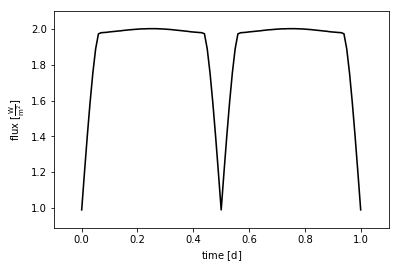

In [16]:
afig, mplfig = b.plot(show=True)

If we now set pblum to be only 2 pi, we should expect the luminosities as well as entire light curve to be scaled in half.

In [17]:
b.set_value('pblum', component='primary', value=2*np.pi)

In [18]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 6.28318531 W>, 'pblum@secondary@lc01': <Quantity 6.28318531 W>, 'pblum_ext@primary@lc01': <Quantity 6.28318531 W>, 'pblum@primary@lc01': <Quantity 6.28318531 W>}


In [19]:
b.run_compute()

Sat, 04 May 2019 13:37 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

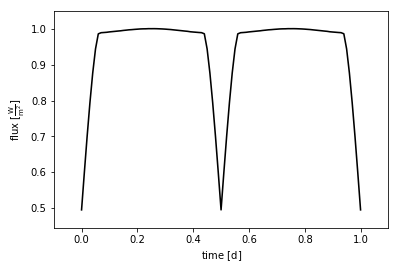

In [20]:
afig, mplfig = b.plot(show=True)

And if we halve the temperature of the secondary star - the resulting light curve changes to the new sum of fluxes, where the primary star dominates since the secondary star flux is reduced by a factor of 16, so we expect a total out-of-eclipse flux of ~0.5 + ~0.5/16 = ~0.53.

In [21]:
b.set_value('teff', component='secondary', value=0.5 * b.get_value('teff', component='primary'))

In [22]:
print(b.filter(qualifier='teff'))

ParameterSet: 2 parameters
          teff@primary@component: 6000.0 K
        teff@secondary@component: 3000.0 K


In [23]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 0.08022599 W>, 'pblum@secondary@lc01': <Quantity 0.08022599 W>, 'pblum_ext@primary@lc01': <Quantity 6.28318531 W>, 'pblum@primary@lc01': <Quantity 6.28318531 W>}


In [24]:
b.run_compute()

Sat, 04 May 2019 13:37 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

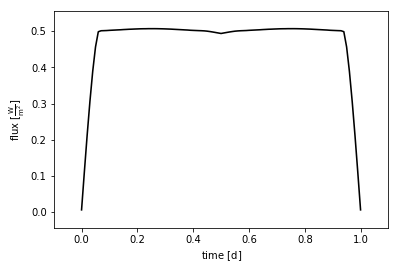

In [25]:
afig, mplfig = b.plot(show=True)

Let us undo our changes before we look at decoupled luminosities.

In [26]:
b.set_value_all('teff', 6000)
b.set_value_all('pblum', 4*np.pi)

### Decoupled Luminosities

The luminosities are decoupled when pblums are provided for the individual components.  To accomplish this, all 'pblum_ref' parameters should be set to 'self'.

In [27]:
b.set_value_all('pblum_ref', 'self')

Now we see that both pblums are available and can have different values.

In [28]:
print(b.filter(qualifier='pblum'))

ParameterSet: 2 parameters
      pblum@primary@lc01@dataset: 12.5663706144 W
    pblum@secondary@lc01@dataset: 12.5663706144 W


If we set these to 4pi, then we'd expect each star to contribute 1.0 in flux units, meaning the baseline of the light curve should be at approximately 2.0

In [29]:
b.set_value_all('pblum', 4*np.pi)

In [30]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


In [31]:
b.run_compute()

Sat, 04 May 2019 13:37 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

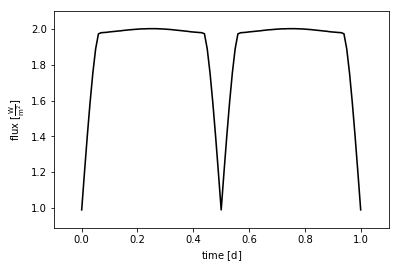

In [32]:
afig, mplfig = b.plot(show=True)

Now let's make a significant temperature-ratio by making a very cool secondary star.  Since the luminosities are decoupled - this temperature change won't affect the resulting light curve very much (compare this to the case above with coupled luminosities).  What is happening here is that even though the secondary star is *cooler*, its luminosity is being rescaled to the same value as the primary star, so the eclipse depth doesn't change (you would see a similar lack-of-effect if you changed the radii).

In [33]:
print(b.filter(qualifier='teff'))

ParameterSet: 2 parameters
          teff@primary@component: 6000.0 K
        teff@secondary@component: 6000.0 K


In [34]:
b.set_value('teff', component='secondary', value=3000)

In [35]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


In [36]:
b.run_compute()

Sat, 04 May 2019 13:37 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

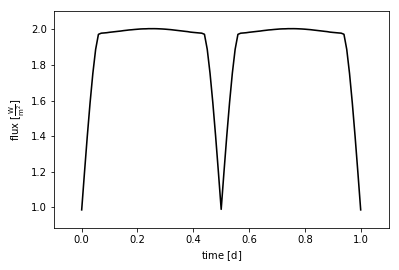

In [37]:
afig, mplfig = b.plot(show=True)

In most cases you will *not want* decoupled luminosities as they can easily break the self-consistency of your model.

Now we'll just undo our changes before we look at accessing model luminosities.

In [38]:
b.set_value_all('teff', 6000)
b.set_value_all('pblum', 4*np.pi)
b['pblum_ref@primary'] = 'self'
b['pblum_ref@secondary'] = 'primary'

pblum_mode = 'absolute'
-----------------------------------

By setting pblum_mode to 'absolute', luminosities and fluxes will be returned in absolute units and not rescaled.  Note that [third light](l3) and [distance](distance) will still affect the resulting flux levels.

In [39]:
b.set_value('pblum_mode', 'absolute')

In [40]:
print(b.filter(qualifier='pblum'))

ParameterSet: 0 parameters
NO PARAMETERS


In [41]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 5.06092179e+25 W>, 'pblum@secondary@lc01': <Quantity 5.06092179e+25 W>, 'pblum_ext@primary@lc01': <Quantity 5.06092179e+25 W>, 'pblum@primary@lc01': <Quantity 5.06092179e+25 W>}


In [42]:
b.run_compute()

Sat, 04 May 2019 13:38 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

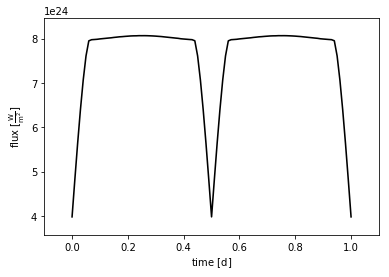

In [43]:
afig, mplfig = b.plot(show=True)

(note the exponent on the y-axis of the above figure)

pblum_mode = 'total flux'
------------------------------

By setting pblum_mode to 'total flux', the user can scale the resulting luminosities and fluxes by the total flux (extrinsic, including [third light](l3)).  Note that the scaling under-the-hood makes the approximation that each star will contribution its luminosity over 4pi (assuming a spherical star) to the overall flux.

In [44]:
b.set_value('pblum_mode', 'total flux')

In [45]:
print(b.get_parameter('pbflux'))

Parameter: pbflux@lc01@dataset
                       Qualifier: pbflux
                     Description: Total passband flux (at t0, including l3 if pblum_mode='total flux')
                           Value: 1.0 W / m2
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: pblum_mode:system flux|total flux



In [46]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 6.28318531 W>, 'pblum@secondary@lc01': <Quantity 6.28318531 W>, 'pblum_ext@primary@lc01': <Quantity 6.28318531 W>, 'pblum@primary@lc01': <Quantity 6.28318531 W>}


In [47]:
b.run_compute()

Sat, 04 May 2019 13:38 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

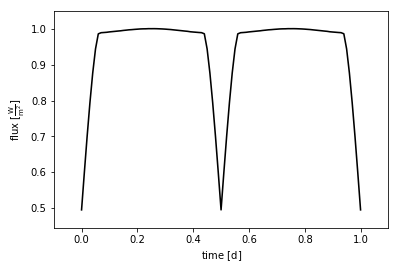

In [48]:
afig, mplfig = b.plot(show=True)

pblum_mode = 'scale to data'
----------------------------------

Setting pblum_mode to 'scale to data' is only allowed if fluxes are attached to the dataset itself.  Let's use our existing model to generate "fake" data and then populate the dataset.

In [49]:
fluxes = b.get_value('fluxes', context='model') * 0.8 + (np.random.random(101) * 0.1)

In [50]:
b.set_value('fluxes', context='dataset', value=fluxes)

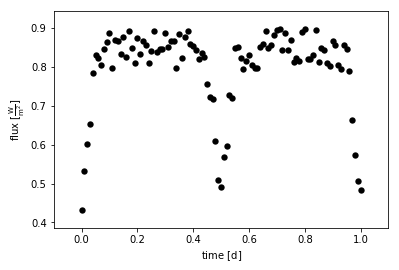

In [51]:
afig, mplfig = b.plot(context='dataset', show=True)

Now if we set pblum_mode to 'scale to data', the resulting model will be scaled to best fit the data.  Note that in this mode we cannot access computed luminosities via [b.compute_pblums](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md).

In [52]:
b.set_value('pblum_mode', 'scale to data')

In [53]:
print(b.compute_pblums())

{}


In [54]:
b.run_compute()

Sat, 04 May 2019 13:38 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

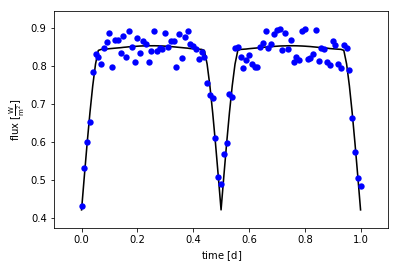

In [55]:
afig, mplfig = b.plot(show=True)

Before moving on, let's reset pblum_mode to 'provided' and remove our fake data

In [56]:
b.set_value('pblum_mode', 'provided')

In [57]:
b.set_value('fluxes', context='dataset', value=[])

pblum_mode = 'color coupled'
--------------------------------

Setting pblum_mode to 'color coupled' allows for the same scaling factor to be applied to two different datasets.  In order to see this in action, we'll add another LC dataset in a different passband.

In [58]:
b.add_dataset('lc', times=phoebe.linspace(0,1,101), passband='Johnson:B', dataset='lc02')

Sat, 04 May 2019 13:39 PARAMETERS   WARNING ld_func='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_func@primary@lc02.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Sat, 04 May 2019 13:39 PARAMETERS   WARNING ld_func='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_func@primary@lc02.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Sat, 04 May 2019 13:39 PARAMETERS   WARNING ld_func='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_func@primary@lc02.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Sat, 04 May 2019 13:39 PARAMETERS   WARNING ld_func='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_func@primary@lc02.  If not addressed, this warning will continue to be raised and will throw an er

<ParameterSet: 20 parameters | contexts: dataset, compute, constraint>

In [59]:
b.set_value_all('ld_func', 'logarithmic')
b.set_value_all('ld_coeffs_source', 'none')
b.set_value_all('ld_coeffs', [0,0])
b.set_value_all('atm', 'blackbody')
b.set_value('irrad_method', 'none')

Sat, 04 May 2019 13:39 PARAMETERS   WARNING ld_func='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_func@primary@lc02.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Sat, 04 May 2019 13:39 PARAMETERS   WARNING ld_func='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_func@primary@lc02.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Sat, 04 May 2019 13:39 PARAMETERS   WARNING ld_func='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_func@primary@lc02.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Sat, 04 May 2019 13:39 PARAMETERS   WARNING ld_func='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_func@primary@lc02.  If not addressed, this warning will continue to be raised and will throw an er

In [60]:
b.set_value('pblum_mode', dataset='lc02', value='color coupled')

Here we see the pblum_mode@lc01 is set to 'provided' with pblum_ref@secondary set to 'primary', meaning it will follow the coupled rules described earlier.  pblum_mode@lc02 is set to 'color coupled' with pblu_ref@lc01 pointing to 'lc01'.

In [61]:
print(b.filter('pblum*'))

ParameterSet: 6 parameters
         pblum_mode@lc01@dataset: provided
  pblum_ref@primary@lc01@dataset: self
  pblum_ref@secondary@lc01@da...: primary
      pblum@primary@lc01@dataset: 12.5663706144 W
         pblum_mode@lc02@dataset: color coupled
   pblum_ref@lc02@lc_dep@dataset: lc01


In [62]:
print(b.compute_pblums())

{'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc02': <Quantity 14.74418694 W>, 'pblum@primary@lc02': <Quantity 14.74418694 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@primary@lc02': <Quantity 14.74418694 W>, 'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc02': <Quantity 14.74418694 W>}


In [63]:
b.run_compute()

Sat, 04 May 2019 13:39 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 4 parameters | datasets: lc02, lc01>

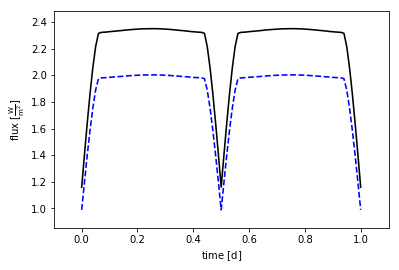

In [64]:
afig, mplfig = b.plot(show=True)

Accessing Model Luminosities
-----------------------------------

Passband luminosities at t0@system per-star (including following all coupling logic) can be computed and exposed on the fly by calling `compute_pblums`.

In [65]:
print b.compute_pblums()

{'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc02': <Quantity 14.74418694 W>, 'pblum@primary@lc02': <Quantity 14.74418694 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@primary@lc02': <Quantity 14.74418694 W>, 'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc02': <Quantity 14.74418694 W>}


By default this exposes 'pblum' and 'pblum_ext' for all component-dataset pairs in the form of a dictionary.  Alternatively, you can pass a label or list of labels to component and/or dataset.

In [66]:
print b.compute_pblums(dataset='lc01', component='primary')

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


For more options, see the [b.compute_pblums API docs](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md).

Note that this same logic is applied (at t0) to initialize all passband luminosities within the backend, so there is no need to call `compute_pblums` before `run_compute`.

In order to access passband luminosities at times other than t0, you can add a mesh dataset and request the pblum_ext column to be exposed.  For stars that have pblum defined (as opposed to coupled to another star in the system), this value should be equivalent to the value of the parameter (at t0 if no features or irradiation are present, and in simple circular cases will probably be equivalent at all times).

Let's create a mesh dataset at a few times and then access the synthetic luminosities.

In [67]:
b.add_dataset('mesh', times=np.linspace(0,1,5), dataset='mesh01', columns=['areas', 'pblum_ext@lc01', 'ldint@lc01', 'ptfarea@lc01', 'abs_normal_intensities@lc01', 'normal_intensities@lc01'])

<ParameterSet: 4 parameters | contexts: compute, dataset>

In [68]:
b.run_compute()

Sat, 04 May 2019 13:39 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 86 parameters | kinds: mesh, lc>

Since the luminosities are passband-dependent, they are stored with the same dataset as the light curve (or RV), but with the mesh method, and are available at each of the times at which a mesh was stored.

In [69]:
print b.filter(qualifier='pblum_ext', context='model').twigs

['00.000000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '00.250000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '00.500000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '00.750000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '01.000000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '00.000000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model', '00.250000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model', '00.500000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model', '00.750000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model', '01.000000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model']


Now let's compare the value of the *synthetic* luminosities to those of the *input* pblum

In [70]:
t0 = b.get_value('t0@system')

In [71]:
print b.get_value(qualifier='pblum_ext', time=t0, component='primary', kind='mesh', context='model')

12.5663706144


In [72]:
print b.get_value('pblum@primary@dataset')

12.5663706144


In [73]:
print(b.compute_pblums(component='primary', dataset='lc01'))

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


In this case, since our two stars are identical, the *synthetic* luminosity of the secondary star should be the same as the primary (and the same as pblum@primary).

In [74]:
print b.get_value(qualifier='pblum_ext', time=t0, component='primary', kind='mesh', context='model')

12.5663706144


In [75]:
print b.get_value(qualifier='pblum_ext', time=t0, component='secondary', kind='mesh', context='model')

12.5663706144


However, if we change the temperature of the secondary star again, since the pblums are coupled, we'd expect the *synthetic* luminosity of the primary to remain fixed but the secondary to decrease.

In [76]:
b['teff@secondary@component'] = 3000

In [77]:
print(b.compute_pblums(dataset='lc01'))

{'pblum_ext@secondary@lc01': <Quantity 0.16045198 W>, 'pblum@secondary@lc01': <Quantity 0.16045198 W>, 'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


In [78]:
b.run_compute()

Sat, 04 May 2019 13:40 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 86 parameters | kinds: mesh, lc>

In [79]:
print b.get_value(qualifier='pblum_ext', time=t0, component='primary', kind='mesh', context='model')

12.5663706144


In [80]:
print b.get_value(qualifier='pblum_ext', time=t0, component='secondary', kind='mesh', context='model')

0.160451977895


And lastly, if we re-enable irradiation, we'll see that the extrinsic luminosities do not match the prescribed value of `pblum` (an intrinsic luminosity).

In [81]:
b.run_compute(irrad_method='horvat')

Sat, 04 May 2019 13:40 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 86 parameters | kinds: mesh, lc>

In [82]:
print b.get_value(qualifier='pblum_ext', time=t0, component='primary', kind='mesh', context='model')

12.5724436159


In [83]:
print b.get_value('pblum@primary@dataset')

12.5663706144


In [84]:
print(b.compute_pblums(dataset='lc01', irrad_method='horvat'))

{'pblum_ext@secondary@lc01': <Quantity 0.1935855 W>, 'pblum@secondary@lc01': <Quantity 0.16045198 W>, 'pblum_ext@primary@lc01': <Quantity 12.57244362 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


Now, we'll just undo our changes before continuing

In [85]:
b.set_value_all('teff@component', 6000)

Role of Pblum
----------------------

Let's now look at the intensities in the mesh to see how they're being scaled under-the-hood.  First we'll recompute our model with the equal temperatures and irradiation disabled (to ignore the difference between pblum and pblum_ext).

In [86]:
b.run_compute()

Sat, 04 May 2019 13:41 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 86 parameters | kinds: mesh, lc>

In [87]:
areas = b.get_value(qualifier='areas', dataset='mesh01', time=t0, component='primary', unit='m^2')
ldint = b.get_value(qualifier='ldint', component='primary', time=t0)
ptfarea = b.get_value(qualifier='ptfarea', component='primary', time=t0)

abs_normal_intensities = b.get_value(qualifier='abs_normal_intensities', dataset='lc01', time=t0, component='primary')
normal_intensities = b.get_value(qualifier='normal_intensities', dataset='lc01', time=t0, component='primary')

'abs_normal_intensities' are the intensities per triangle in absolute units, i.e. W/m^3.

In [88]:
np.median(abs_normal_intensities)

30448834948512.58

The values of 'normal_intensities', however, are significantly samller (in this case).  These are the intensities in relative units which will eventually be integrated to give us flux for a light curve.

In [89]:
np.median(normal_intensities)

7.560506972544786e-12

'normal_intensities' are scaled from 'abs_normal_intensities' **so that** the computed luminosity matches the prescribed luminosity (pblum).

Here we compute the luminosity by summing over each triangle's intensity in the normal direction, and multiply it by pi to account for blackbody intensity emitted in all directions in the solid angle, and by the area of that triangle.

In [90]:
pblum = b.get_value(qualifier='pblum', component='primary', context='dataset')
print np.sum(normal_intensities * ldint * np.pi * areas) * ptfarea, pblum

12.56637061435917 12.5663706144
